Taken from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvi

Global seed set to 0


In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2022-03-18 16:22:43.749212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 16:22:43.749282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


In [3]:
covid = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211001_annot_patient_integrated.h5ad')
covid

AnnData object with n_obs × n_vars = 300353 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'used_for_scvi'
    uns: 'cell_type_colors', 'hvg', 'infected_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
melms = sc.read('melms2021/Melms_2021.h5ad')
melms

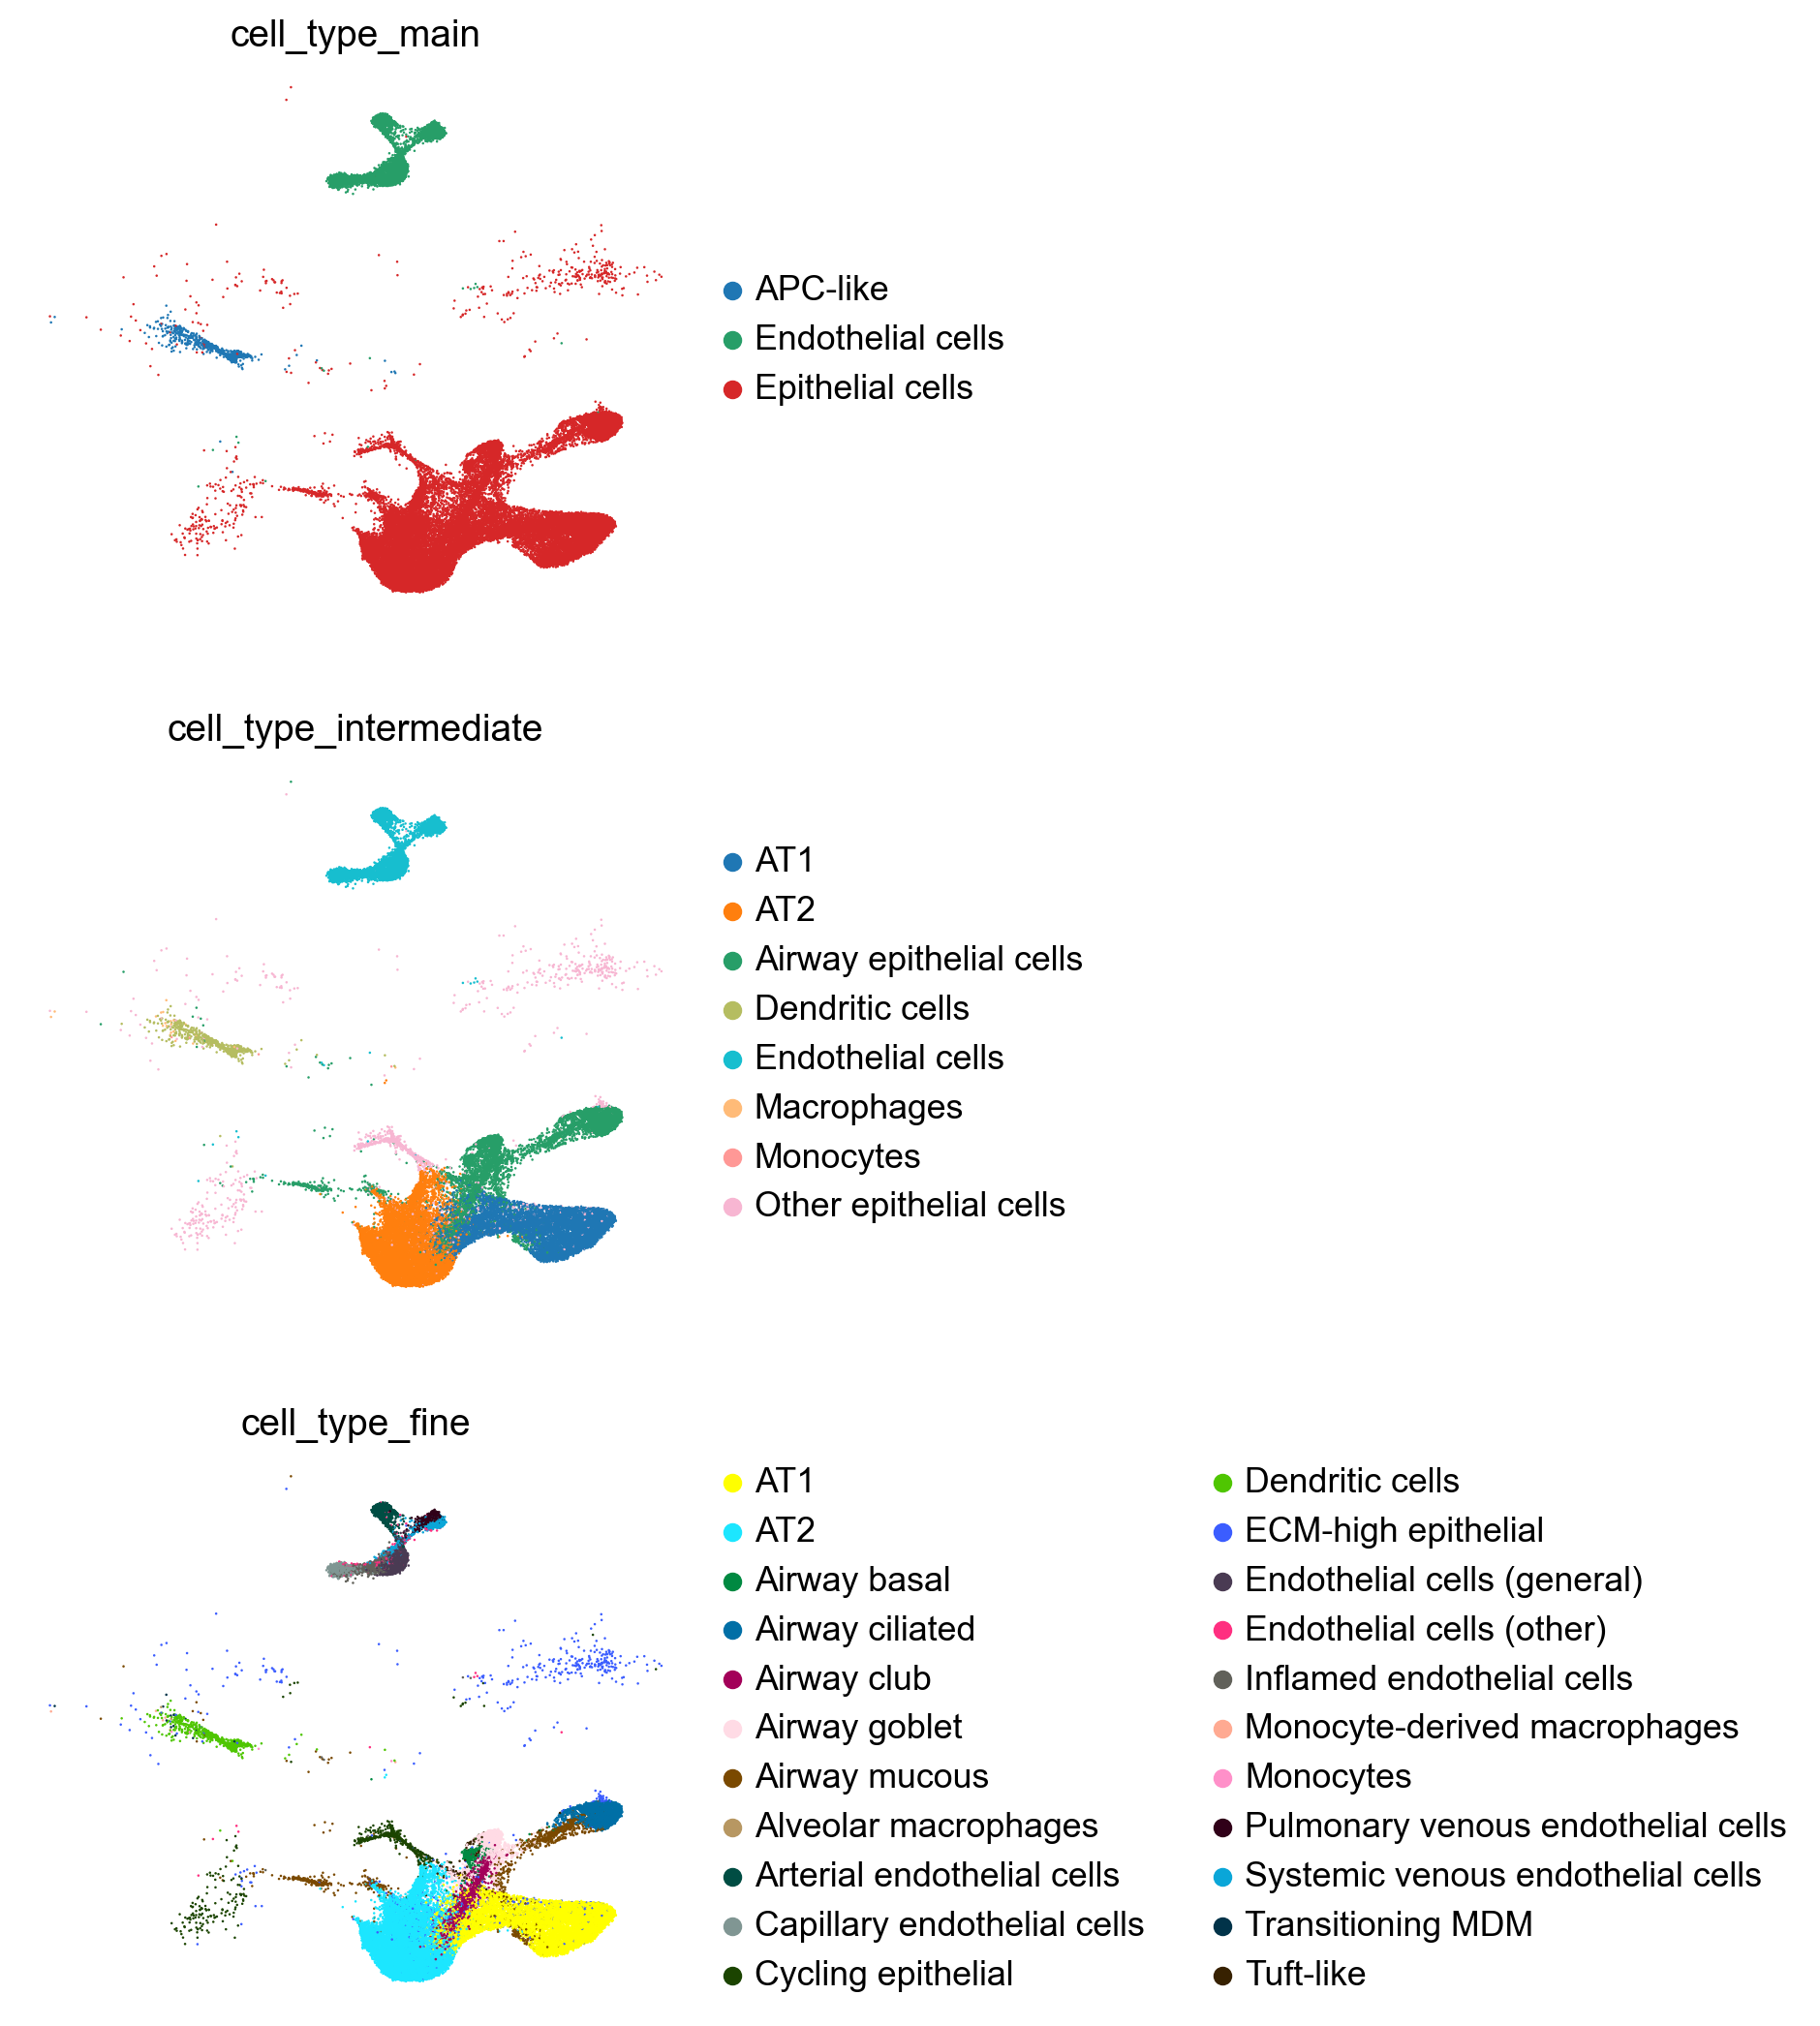

In [9]:
sc.pl.umap(melms, color=['cell_type_main', 'cell_type_intermediate', 'cell_type_fine'], ncols=1)

## Data processing

Remove cells without a treatment label and subsample to decrease runtime. Only use patient 4 this time to see if scvi will improve batch mixing.

In [5]:
covid = covid[covid.obs.patient == 'patient_4']
covid = covid[~covid.obs.treatment.isin(['nan', 'mock'])]
covid = covid.concatenate(sc.pp.subsample(covid[covid.obs.treatment == 'mock'], .3, copy=True))
covid

AnnData object with n_obs × n_vars = 71626 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'used_for_scvi'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'

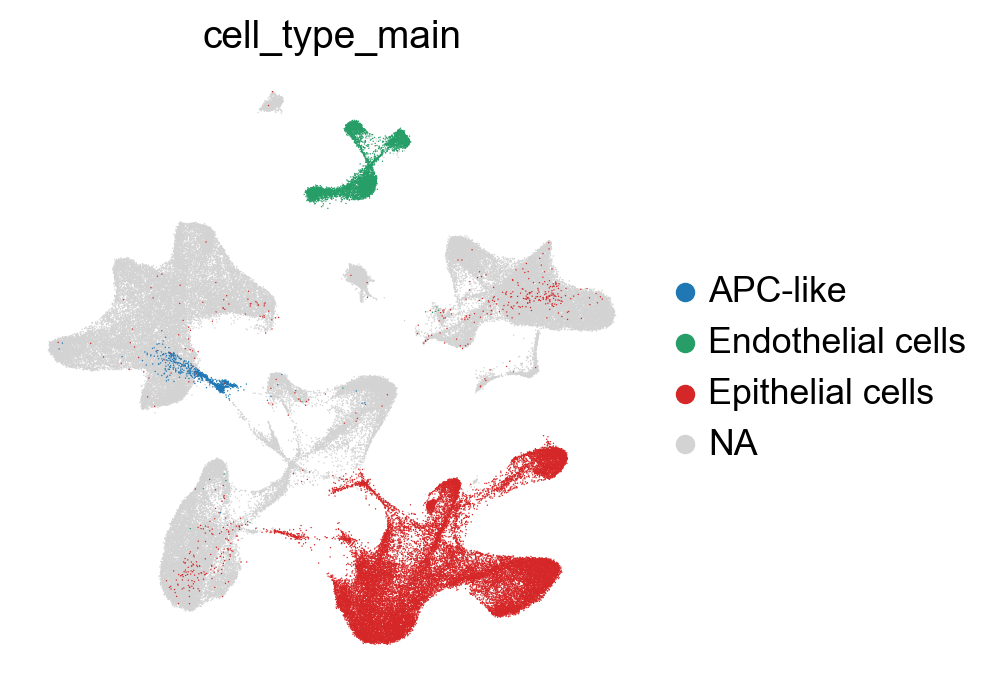

In [6]:
sc.pl.umap(
    melms, 
    color='cell_type_main',
    groups=['APC-like', 'Endothelial cells', 'Epithelial cells']
)

In [8]:
melms = melms[melms.obs.cell_type_main.isin(['APC-like', 'Endothelial cells', 'Epithelial cells'])]
melms

View of AnnData object with n_obs × n_vars = 36304 × 34546
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'group', 'cell_type_main', 'cell_type_intermediate', 'cell_type_fine', 'initial_clustering', 'age', 'sex', 'recorded_race', 'recorded_ethnicity', 'intubation_days', 'interval_death_symptoms_onset_days', 'pmi_h', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'biosample_id_colors', 'cell_type_fine_colors', 'cell_type_intermediate_colors', 'cell_type_main_colors', 'disease__ontology_label_colors', 'disease_colors', 'donor_id_colors', 'group_colors', 'hvg', 'leiden', 'library_preparation_protocol__ontology_label_colors', 'library_preparation_protocol_colors', 'neighbors', 'organ__ontology_label_colors', 'organ_colors', 'pca', 'recorded_ethnicity_colors', 'recorded_ra

Harmonized cell type names.

In [7]:
melms.obs['cell_type'] = melms.obs['cell_type_intermediate']
melms.obs['cell_type'] = [s.lower() for s in melms.obs['cell_type']]

Trying to set attribute `.obs` of view, copying.


Label batches.

In [8]:
melms.obs['batch_data'] = 'melms'
covid.obs['batch_data'] = covid.obs['patient']

Trying to set attribute `.obs` of view, copying.


#### Combine data

In [9]:
adata = covid.concatenate(melms)
# adata.obs.batch_data.value_counts()

In [ ]:
adata.var_names

In [12]:
adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch_data",
    subset=True
)
adata

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch_data' as categorical
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

AnnData object with n_obs × n_vars = 133952 × 2000
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', 'batch_data', 'patients', 'sample_ID', 'data_set', 'severity', 'location', 'condition', 'age', 'sex', 'virus_positive', 'PBMC_leiden_29', 'patient_category', 'reactive_clonotype', 'published_meta_celltype', 'published_celltype', 'harmonized_celltype', 'T_cell_type', 'size_factors', 'pct_mitochondrial'
    var: 'highly_variable-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [13]:
# scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch_data")
scvi.model.SCVI.setup_anndata(adata, batch_key="patient", layer="counts")

INFO     Using batches from adata.obs["batch_data"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 133952 cells, 2000 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


## scVI integration

Take top 2k genes from those shared between datasets.

In [9]:
intersect = set(covid.var_names) & set(melms.var_names)
covid = covid[:, list(intersect)]
covid

AnnData object with n_obs × n_vars = 190722 × 18023
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', 'batch_data'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [10]:
sc.pp.highly_variable_genes(
    covid,
    n_top_genes=2000,
    batch_key="patient",
    subset=True
)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
covid.X.toarray()

array([[0.       , 1.089256 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.045769 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.7987981, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.7537056, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [12]:
scvi.model.SCVI.setup_anndata(covid, layer="counts", labels_key='treatment', batch_key="patient")

INFO     Using batches from adata.obs["patient"]                                             
INFO     Using labels from adata.obs["treatment"]                                            
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 190722 cells, 2000 vars, 4        
         batches, 16 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [13]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    n_latent=30,
)

vae_ref = scvi.model.SCVI(
    covid,
    **arches_params
)
vae_ref.train(early_stopping=True, max_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.90s/it, loss=599, v_num=1]


In [14]:
vae_ref.save('2021-12-07_scvi_vae_patient_melms_map', overwrite=True)

In [15]:
covid.X.toarray()

array([[0.       , 1.089256 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.045769 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.7987981, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.7537056, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

#### plot embedding

In [9]:
covid.obsm["X_scVI"] = vae_ref.get_latent_representation()

In [10]:
%%time
sc.pp.neighbors(covid, use_rep="X_scVI")
sc.tl.umap(covid)

CPU times: user 22min 18s, sys: 4min 4s, total: 26min 23s
Wall time: 4min 38s


In [11]:
# relabel
import pandas as pd
import math
covid.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in covid.obs.treatment_virus.values]
covid.obs['infected'] = covid.obs['infected'].astype('category')

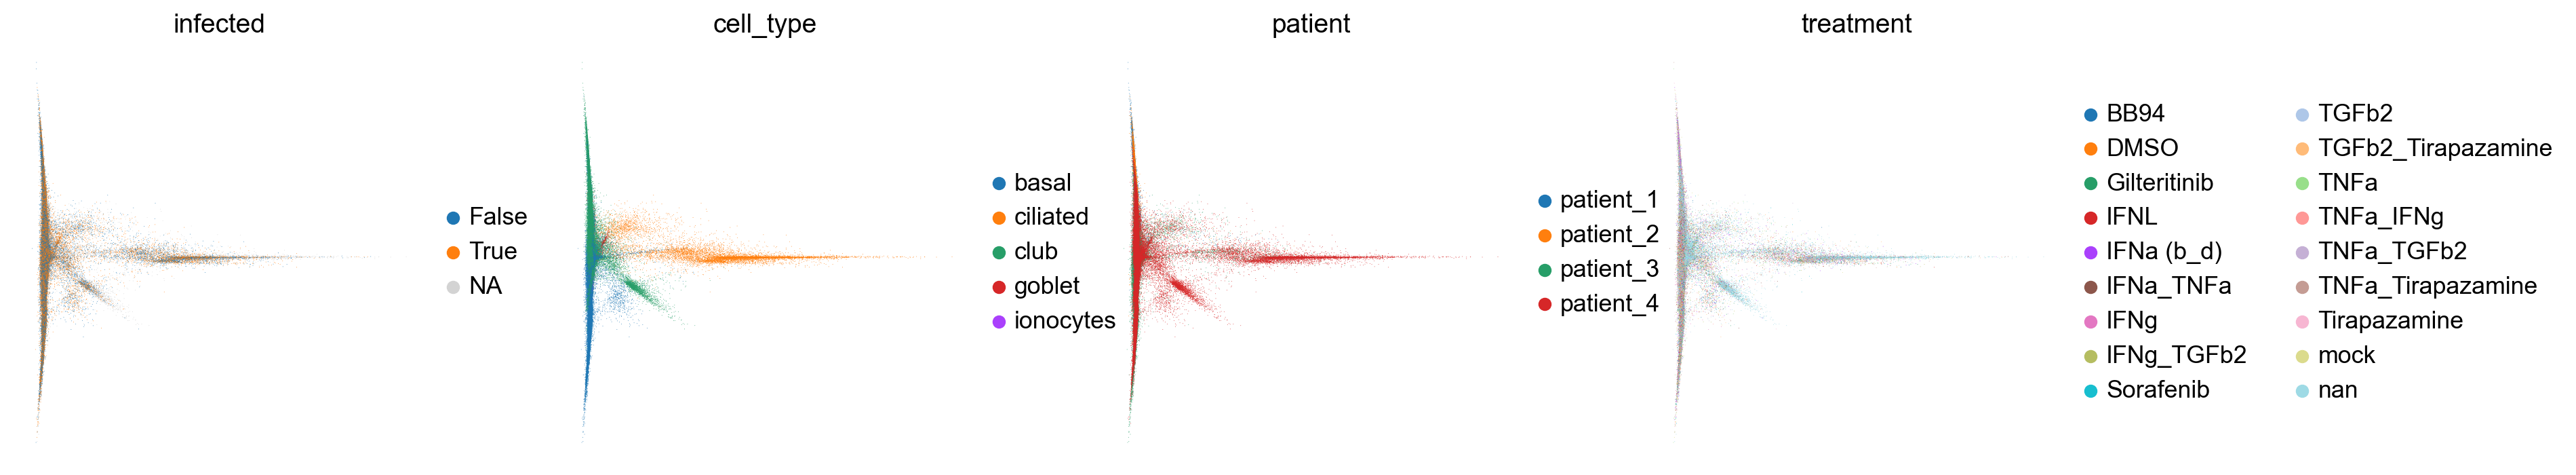

In [12]:
sc.pl.umap(covid, color=['infected', 'cell_type', 'patient', 'treatment'])

Not sure what's going wrong here... Might be that the neighbors code changed somehow.

## scANVI label transfer

In [16]:
# check
len(set(covid.var_names[covid.var['highly_variable']]) & set(melms.var_names))

2000

In [10]:
# sc.pp.highly_variable_genes(
#     covid,
#     n_top_genes=2000,
#     batch_key="patient"
# )

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# adata.obs["treatment_scanvi"] = 'Unknown'
# melms_idx = adata.obs['batch_data'] != "melms"
# adata.obs["treatment_scanvi"][melms_idx] = adata.obs.treatment[melms_idx]

In [ ]:
# scvi.model.SCANVI.setup_anndata(
#     adata,
#     layer="counts",
#     batch_key="batch_data",
#     labels_key="treatment_scanvi",
# )

In [21]:
melms.obs['patient'] = 'melms'
melms.obs['treatment'] = 'Unknown'

In [22]:
vae_q = scvi.model.SCANVI.load_query_data(
    melms[:, covid.var_names[covid.var['highly_variable']]],  # containing unlabeled cells
    '2021-12-07_scvi_vae_patient_melms_map',   # path to model trained on just reference data
)

# specify where to put the labels
vae_q._unlabeled_indices = np.arange(melms.n_obs)
vae_q._labeled_indices = []

Trying to set attribute `.uns` of view, copying.


INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 62326 cells, 2000 vars, 5 batches,
         17 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


TypeError: __init__() missing 1 required positional argument: 'unlabeled_category'

In [ ]:
# lvae = scvi.model.SCANVI.from_scvi_model(vae, "Unknown", adata=adata)

In [ ]:
# lvae.train(max_epochs=20, n_samples_per_label=100)
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

#### Predict

In [28]:
# adata.obs["treatment_predicted"] = lvae.predict(adata)
# adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


In [29]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'severity_virus' as categorical


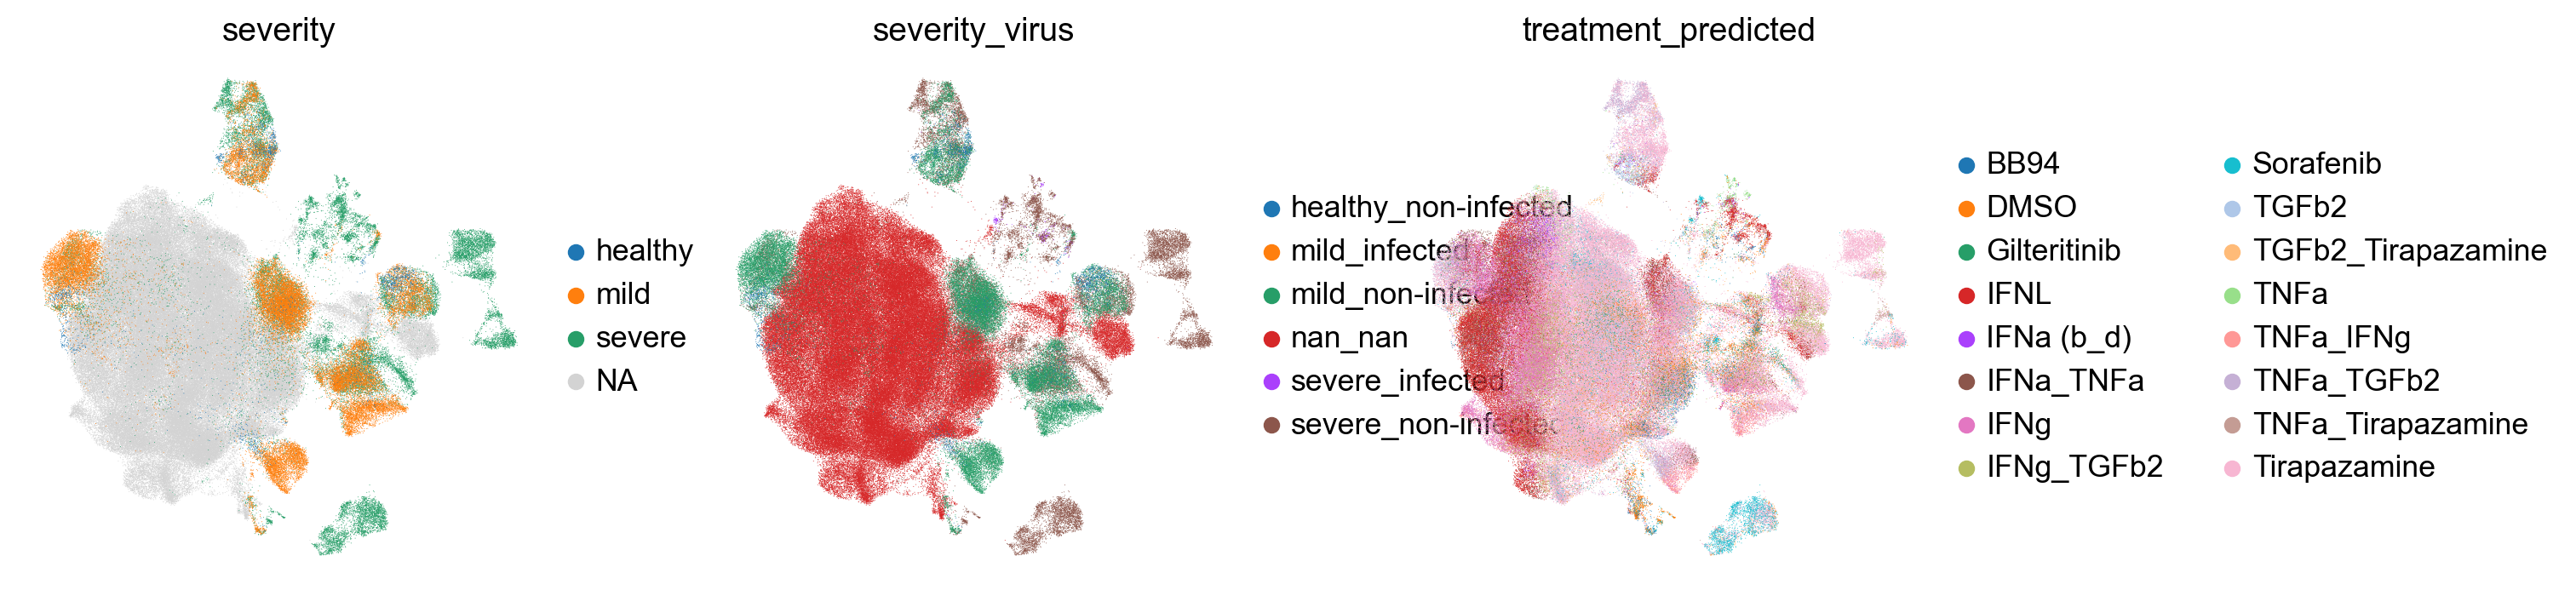

In [48]:
adata.obs['severity_virus'] = adata.obs.severity.astype(str) + '_' + adata.obs.virus_positive.astype(str)
sc.pl.umap(adata, color=['severity', 'severity_virus', 'treatment_predicted'])

Confusion matrix of patient qualities and treatment labels.

<AxesSubplot:xlabel='severity_virus', ylabel='treatment_predicted'>

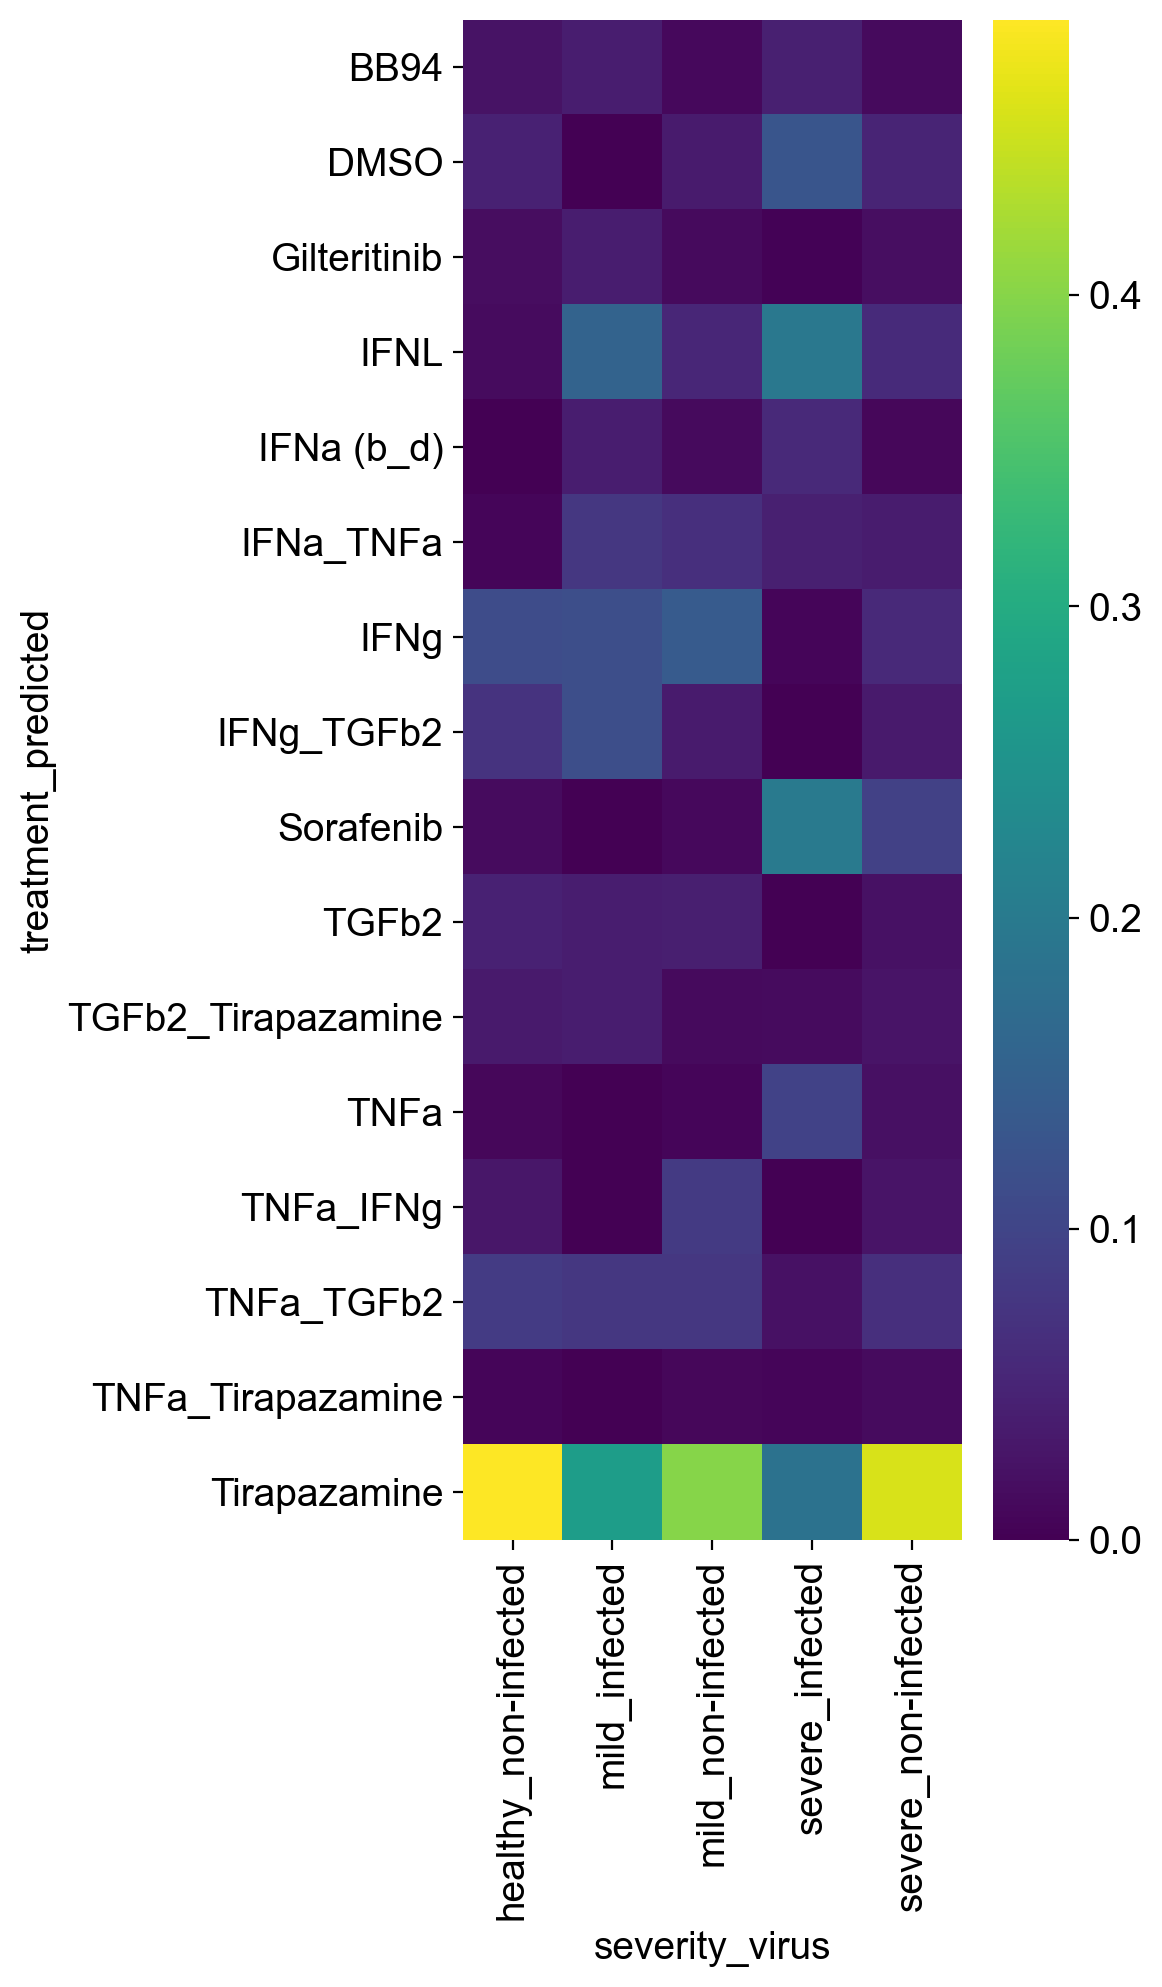

In [55]:
# normalized on columns
df = adata.obs.groupby(["severity_virus", "treatment_predicted"]).size().unstack(fill_value=0).T
df = df / df.sum(axis=0)
plt.figure(figsize=(4, 10))
sns.heatmap(df.drop(labels=['nan_nan'], axis=1), cmap='viridis')

## labeling with DIALOGUE programs

In [4]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211005_melms_integrated.h5ad')

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'severity_virus' as categorical


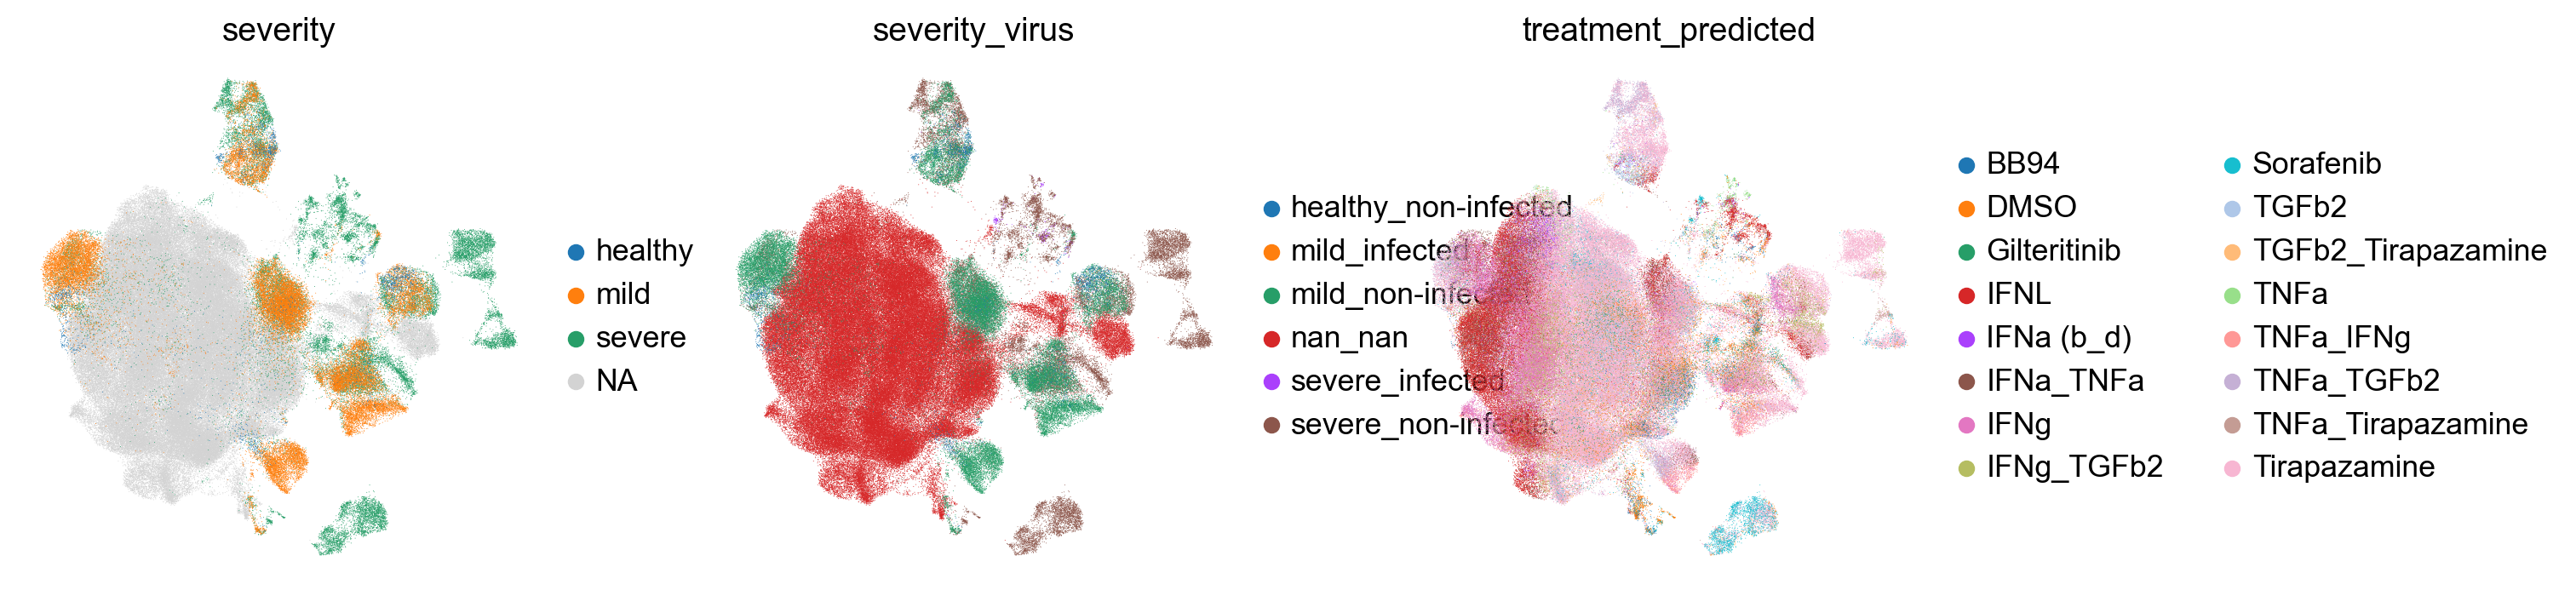

In [6]:
adata.obs['severity_virus'] = adata.obs.severity.astype(str) + '_' + adata.obs.virus_positive.astype(str)
sc.pl.umap(adata, color=['severity', 'severity_virus', 'treatment_predicted'])

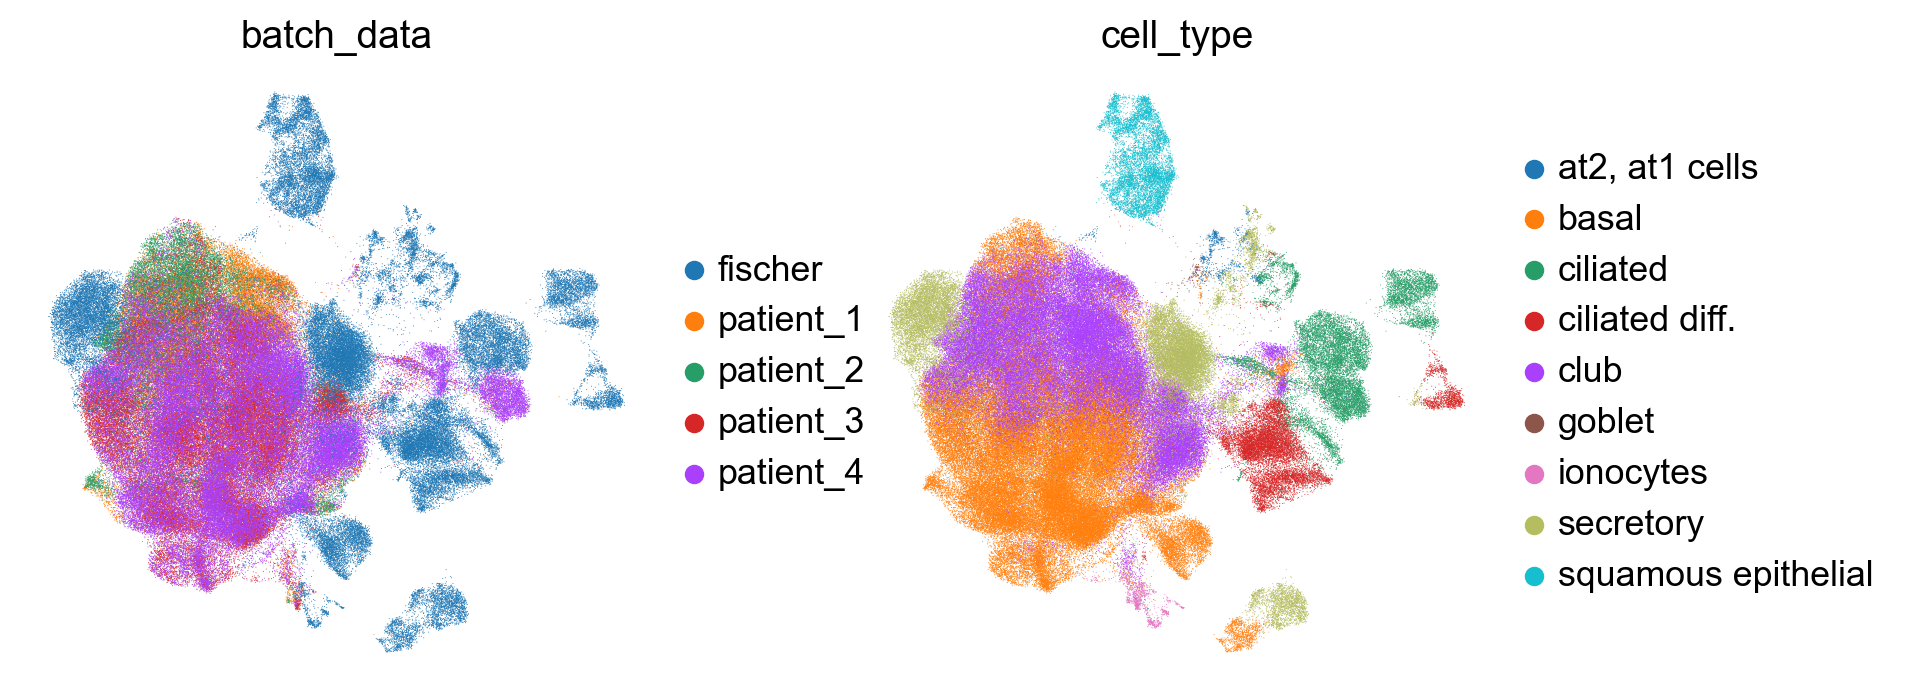

In [7]:
sc.pl.umap(adata, color=['batch_data', 'cell_type'], ncols=3)

In [5]:
import pickle5 as pickle
with open('main_results_dict.pkl', 'rb') as handle:
    dic = pickle.load(handle)

In [11]:
mcp_dict = {}
for k, v in dic.items():
    mcp = sum(list(v.values()), [])
    mcp = set(adata.var_names) & set(mcp)
    mcp_dict[k] = list(mcp)

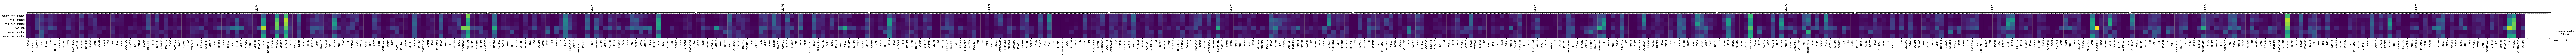

In [12]:
sc.pl.matrixplot(adata, mcp_dict, groupby='severity_virus')

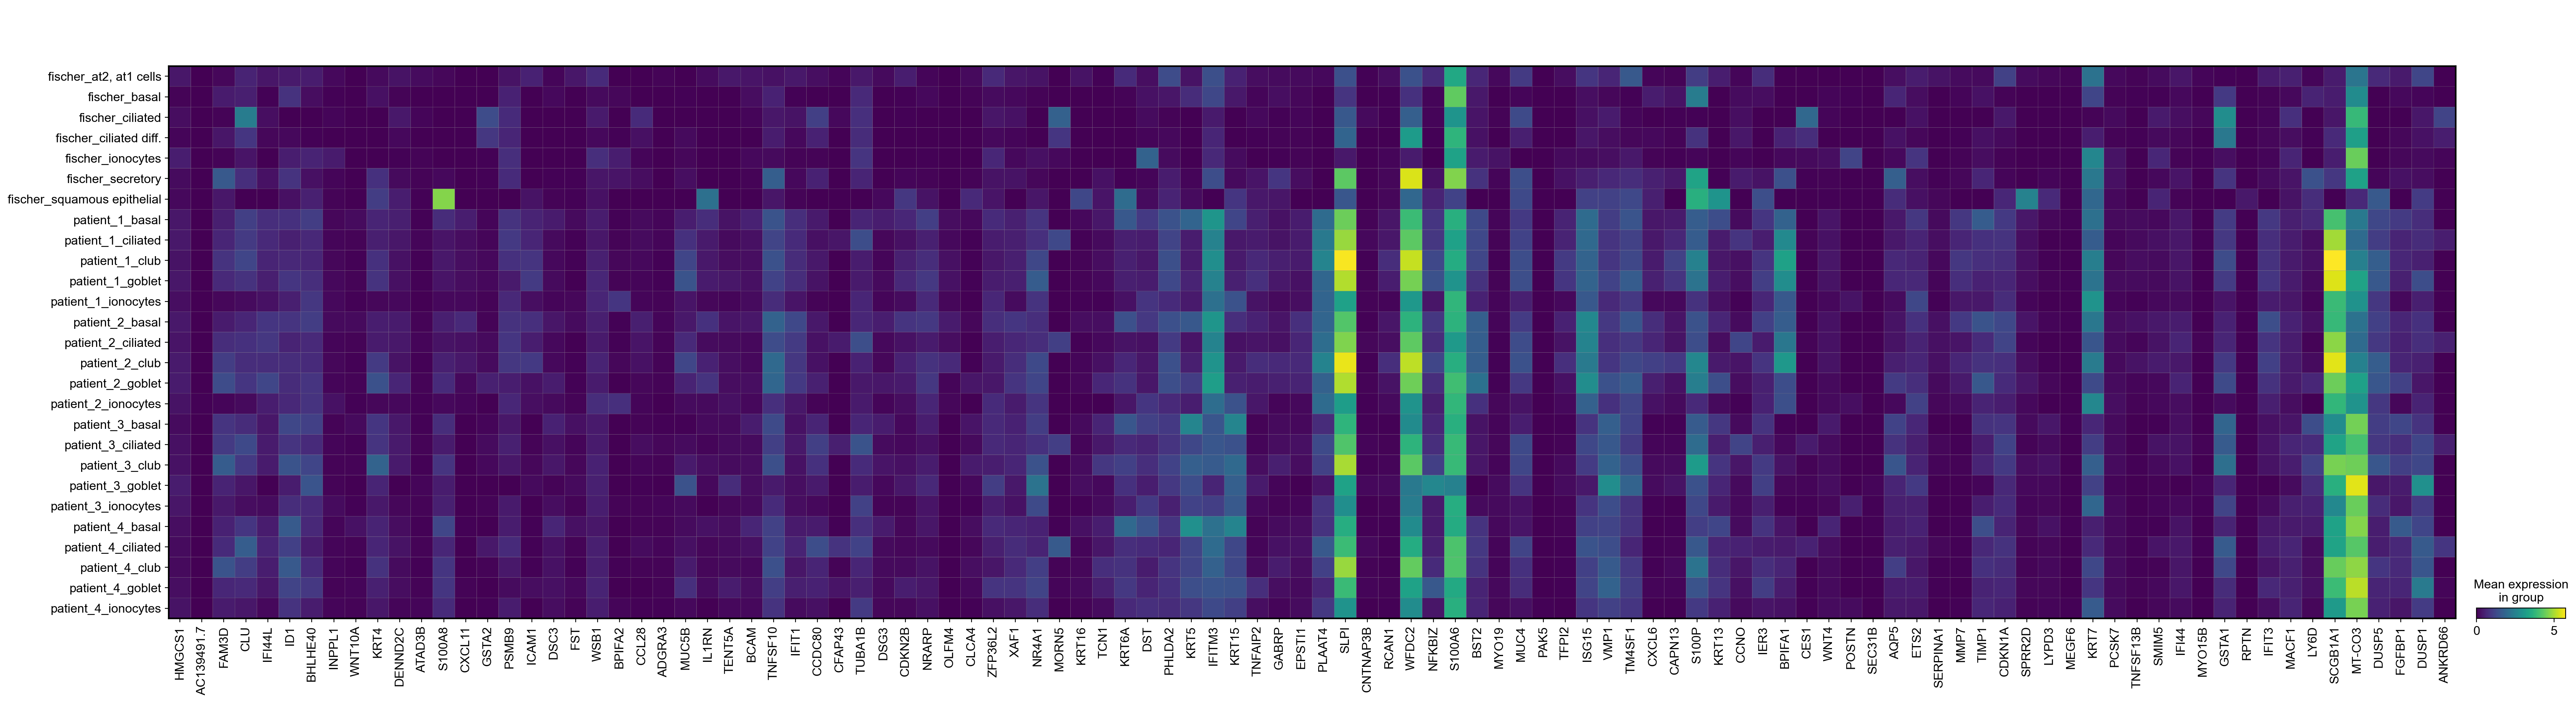

In [17]:
sc.pl.matrixplot(adata, mcp_dict['MCP1'], groupby=['batch_data', 'cell_type'])

What we'd want to see here is a _pattern_ of expression from cell type to cell type that is shared, enough to align both the cell types and which demonstrates that we can align the perturbation effect (as defined by MCP1).

In [ ]:
pd.crosstab(adata.obs.cell_type, adata.obs.)

## Save

In [56]:
sc.write('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211005_melms_integrated.h5ad', adata)

In [57]:
lvae.save('2021-10-10_scanvi_lvae_patient_melms_labels')